# Across-Sessions Within Subject Testing with [glhmm toolbox](https://github.com/vidaurre/glhmm)

In this tutorial, we are going to look at how to implement the across sessions within subject testing using the [glhmm toolbox](https://github.com/vidaurre/glhmm).
This test is used for studying variability between different sessions in studies spanning multiple scanning sessions and is therefore ideal for longitudinal studies.

In the real world scenarios, one would typically fit a Hidden Markov Model (HMM) to an actual dataset. However, for the sake of showing the concept of statistical testing, we just use synthetic data for both the independent variable  and the dependent variable for the ```across_sessions_within_subject``` test.

We create synthetic data using the toolbox [Genephys](https://github.com/vidaurre/genephys), developed by Vidaurre in 2023 (accessible at [https://doi.org/10.7554/eLife.87729.2](https://elifesciences.org/reviewed-preprints/87729)). 
[Genephys](https://github.com/vidaurre/genephys) makes it possible to simulate electrophysiological data in the context of a psychometric experiment. Hence, it can create scenarios where, for example, a subject is exposed to one or multiple stimuli while simultaneously recording EEG or MEG data.

While the process of preparing the data requires some explanation, executing the test (```across_sessions_within_subject```) itself is straightforward —simply input the variables ```D``` and ```R```, and define the specific ```method``` you wish to apply. The methods include permutation using regression or permutation using correlation and is described in the paper [Vidaurre et al. 2023](https://arxiv.org/abs/2312.07151#:~:text=GLHMM%20is%20implemented%20as%20a,sets%20at%20reasonable%20computational%20time).

## Table of Contents
1. [Load and prepare data](#load-data)
    * [Look at data](#look-data)
    * [Prepare data for HMM](#prep_hmm)
2. [Load data or initialise and train HMM](#load_hmm)
    * [Data restructuring](#data-recon)
3. [Across-sessions within subject testing](#across_sessions)
    * [Across-sessions within subject testing - Regression](#perm-regression)
    * [Across-sessions within subject testing - Correlation](#perm-correlation)

### Install necessary packages
If you dont have the **GLHMM-package** installed, then run the following command in your terminal:

```pip install git+https://github.com/vidaurre/glhmm```

### Import libraries
Let's start by importing the required libraries and modules.

In [101]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from glhmm import glhmm, graphics, statistics,preproc

## 1. Load and prepare data <a id="load-data"></a>
First, we'll load the synthetic data from this [folder](https://github.com/vidaurre/glhmm/tree/main/docs/notebooks/data_statistical_testing) and use the [glhmm toolbox](https://github.com/vidaurre/glhmm) to train a classic HMM on the synthetic data that represents EEG or MEG measurements.\
Let's start by loading the essential data for this tutorial:

In [102]:
# Get the current directory
PATH_PARENT = Path.cwd()
# Path of the location of the data
PATH_DATA = PATH_PARENT / "data_statistical_testing"

# Load D data
D_sessions = np.load(PATH_DATA/"D_sessions.npy")
# Load R data
R_sessions = np.load(PATH_DATA/"R_sessions.npy")
# Load indices
idx_sessions = np.load(PATH_DATA/"idx_sessions.npy")

print(f"Data dimension of D-session data: {D_sessions.shape}")
print(f"Data dimension of R-session data: {R_sessions.shape}")
print(f"Data dimension of indices: {idx_sessions.shape}")

Data dimension of D-session data: (250, 1500, 16)
Data dimension of R-session data: (1500,)
Data dimension of indices: (10, 2)


### Look at data <a id="look-data"></a>
Now we can look at the data structure.
- D_sessions: 3D array of shape (n_timepoints, n_trials, n_features)
- R_sessions: 3D array of shape (n_trials,)
- idx_sessions: 2D array of shape (n_sessions, 2)

```D_sessions``` represents the data collected from the subject, structured as a list with three elements: ```[250, 1500, 16]```. The first element indicates that the subject underwent measurement across ```250``` timepoints. The second element, ```1500```, corresponds to the total number of trials conducted. In this context, 10 distinct sessions were executed, each comprising 150 trials, lead up to a total of 1500 trials (150*10). Each individual trial involved the measurement of ```16``` channels within the EEG or MEG scanner.

```R_sessions``` simulates the measured reaction time for each trial that the subject undergoes at different sessions. 

Lastly, we have ```idx_sessions = [10, 2]```. This indicates the number of sessions conducted, which in this case is ```10```. The values in each row represent the start and end indices of the trials.



### Prepare data for HMM <a id="prep_hmm"></a>
When you're getting into training a Hidden Markov Model (HMM), the input data needs to follow a certain setup. The data shape should look like ((number of timepoints * number of trials), number of features). This means you've lined up all the trials from different sessions side by side in one long row. The second dimension is the number of features, which could be the number of parcels or channels. 

So, in our scenario, we've got this data matrix, ```D_session```, shaped like ```[250, 1500, 16]``` (timepoints, trials, channels). Now, when we bring all those trials together, it's like stacking them up to create a new design matrix, and it ends up with a shape of ```[375000, 16]``` (timepoints * trials, channels). 
Beside that we also need to update ```R_session``` and ```idx_sessions``` to sync up  with the newly concatenated data. To make life easier, we've got the function ```get_concatenate_sessions```. It does the heavy lifting for us.

In [103]:
D_con,R_con,idx_con=statistics.get_concatenate_sessions(D_sessions, R_sessions, idx_sessions)
print(f"Data dimension of the concatenated D-data: {D_con.shape}")
print(f"Data dimension of the concatenated R-data: {R_con.shape}")
print(f"Data dimension of the updated time stamp indices: {idx_con.shape}")

Data dimension of the concatenated D-data: (375000, 16)
Data dimension of the concatenated R-data: (375000,)
Data dimension of the updated time stamp indices: (10, 2)


For a quick sanity check, let's verify whether the concatenation was performed correctly on ```D_sessions```. We've essentially stacked up every timepoint from each trial sequentially.

To do this, we can compare a slice of our original design matrix, say ```D_sessions[:, 0, :]```, with the corresponding slice in the concatenated data, ```D_con[0:250, :]```.\
If the comparison ```D_sessions[:, 0, :] == D_con[0:250, :]``` holds true, we're essentially confirming that all timepoints in the first trial align perfectly with the first 250 values in our concatenated data. It's like double-checking to make sure everything lined up as expected.

In [104]:
D_sessions[:,0,:]==D_con[0:250,:]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Here, it's evident that the concatenation process has been executed accurately.

Next up, let's confirm if the values in ```idx_con``` have been appropriately updated. Each row in this matrix should represent the total count of timepoints and trials for each of the 10 sessions. In our case, it should total to 37500 for each session (calculated as 250 time points * 150 trials). 

In [105]:
# Look at idx_con
idx_con

array([[     0,  37500],
       [ 37500,  75000],
       [ 75000, 112500],
       [112500, 150000],
       [150000, 187500],
       [187500, 225000],
       [225000, 262500],
       [262500, 300000],
       [300000, 337500],
       [337500, 375000]])

Indeed, each session now aligns with ```37500``` datapoints. This means that when we pooled together the timepoints and trials, the count for each session ended up exactly as expected. It's a reassuring confirmation that our concatenation didn't miss a beat.

**Please take note: If the measurements haven't been continuously recorded within a single session but have been pre-processed and exported on a trial-by-trial basis, we'll need to construct the indices in a different manner. In our case, where we have 250 timepoints for each trial, where each trial consists of 250 timepoints and there are a total of 1500 trials, the indices must be created by specifying the start and end timepoints for each trial.**

You can create these indices using the ```get_timestamp_indices``` function. The following example will guide you through the process.


In [106]:
idx_trials =statistics.get_indices_timestamp(D_sessions.shape[0], D_sessions.shape[1])
print(f"Values in index:\n{idx_trials}\n")
print(f"Shape of index: {idx_trials.shape}")

Values in index:
[[     0    250]
 [   250    500]
 [   500    750]
 ...
 [374250 374500]
 [374500 374750]
 [374750 375000]]

Shape of index: (1500, 2)


**NOTE: It is important to standardise your timeseries and, if necessary, apply other kinds of preprocessing before fitting the model.**\
This will be done separately for each session/subject as specified in the indices. The data provided here are already close to standardised (so the code below will not do much), but see [Prediction tutorial](./Prediction_example.ipynb) to see the effect on real data. 

In [107]:
D_con_preproc,_ = preproc.preprocess_data(D_con, idx_trials)

## 2. Load data or initialise and train HMM <a id="load_hmm"></a>

You can either load the Gamma values from a pretrained model or train your own model. If you prefer the former option, load up the data from the [data_statistical_testing](https://github.com/vidaurre/glhmm/tree/main/docs/notebooks/data_statistical_testing) folder. 

```python
current_directory = os.getcwd()
folder_name = "\\data_statistical_testing" 

# Define file name
file_name = '\\Gamma_sessions.npy'
# Define file path
file_path = os.path.join(current_directory+folder_name+file_name)
# Load Gamma
Gamma = np.load(file_path)
print(f"Data dimension of Gamma: {Gamma.shape}")
```
The GLHMM model in question has been trained utilizing a Gaussian observation model, incorporating mean and covariance parameters for 8 distinct states.\
However, if you would rather train your own model, you can use the variables ```D_con``` and ```idx_con``` as inputs and and complete this section.

Our modeling approach involves representing states as Gaussian distributions with mean and a full covariance matrix. This means that each state is characterized by a mean amplitude and a functional connectivity pattern. To specify this configuration, set ```covtype='full'``` and the number of states to ```K=6```. If you prefer not to model the mean, you can include ```model_mean='no'```. Optionally, you can check the hyperparameters to make sure that they correspond to how you want the model to be set up.

In [92]:
# Create an instance of the glhmm class
K = 6 # number of states
hmm = glhmm.glhmm(model_beta='no', K=K, covtype='full')
print(hmm.hyperparameters)

{'K': 6, 'covtype': 'full', 'model_mean': 'state', 'model_beta': 'no', 'dirichlet_diag': 10, 'connectivity': None, 'Pstructure': array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]]), 'Pistructure': array([ True,  True,  True,  True,  True,  True])}


**Train an HMM**\
Now, let's proceed to train the HMM using the loaded data (```D_con```) and time indices (```idx_con```).

Since in this case, we are not modeling an interaction between two sets of timeseries but opting for a "classic" HMM, we set ```X=None```. For training, ```Y``` should represent the timeseries from which we aim to estimate states (```D_con```), and indices should encompass the beginning and end indices of each subject (```idx_con```).

In [93]:
Gamma,Xi,FE = hmm.train(X=None, Y=D_con_preproc.astype(np.float64), indices=idx_trials)

Init repetition 1 free energy = 10354563.851963297
Init repetition 2 free energy = 10377313.770013683
Init repetition 3 free energy = 10356242.947210863
Init repetition 4 free energy = 10330968.89228287
Init repetition 5 free energy = 10333805.551470168
Best repetition: 4
Cycle 1 free energy = 10322590.668932866
Cycle 2 free energy = 10307340.459967773
Cycle 3, free energy = 10299993.28990281, relative change = 0.3251337270216641
Cycle 4, free energy = 10294715.122511037, relative change = 0.18934758486527564
Cycle 5, free energy = 10290554.895464364, relative change = 0.12986191985539738
Cycle 6, free energy = 10287341.135101087, relative change = 0.0911717124718316
Cycle 7, free energy = 10285057.940006314, relative change = 0.06083211000301936
Cycle 8, free energy = 10283565.619647242, relative change = 0.03824006340515883
Cycle 9, free energy = 10282628.216275621, relative change = 0.023457103087764917
Cycle 10, free energy = 10282027.23328269, relative change = 0.01481587994945242

As you can see, the datapoints in Gamma correspond to the concatenated data (```375000```), and the number of columns represent the six different states.

In [109]:
Gamma.shape

(375000, 6)

### Data restructuring <a id="data-recon"></a>
Now we have trained our HMM and got our ```Gamma```  values we need to restructure the data back to the original data structure. In this case we are not doing HMM-aggregated statistics, but we will instead perform the statistical testing per time point. 
We will acheive this by applying the function ```reconstruct_concatenated_design```. It takes a concatenated 2D matrix and converts it into a 3D matrix. 
So, it will convert  ```Gamma```, shaped like ```[375000, 6]``` back to the original format for number of time points and trials shaped like ```[250, 1500, 6]``` (timepoints, trials, channels).

In [131]:
# Reconstruct the Gamma matrix
n_timepoints, n_trials, n_channels = D_sessions.shape[0],D_sessions.shape[1],Gamma.shape[1]
gamma_epoch =statistics.reconstruct_concatenated_to_3D(Gamma,n_timepoints=n_timepoints, n_trials=n_trials, n_channels=n_channels)

As a sanity check we will see if ```gamma_epoch``` is actually structured correctly by comparing it with ```Gamma```.

To do this, we can compare a slice of our 3D-matrix, like ```gamma_epoch[:, 0, :]```, with the corresponding slice in the concatenated 2D-data, ```Gamma[0:250, :]```.\
If the comparison ```gamma_epoch[:, 0, :] == Gamma[0:250, :]``` holds true, we're essentially confirming that all timepoints in the first trial align perfectly with the first 250 values in our concatenated data. 



In [132]:
gamma_epoch[:, 0, :] == Gamma[0:250, :]

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       ...,
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

## 3. Across-sessions within subject testing <a id="across_sessions"></a>
As we transition to the next phase of this tutorial, we will learn how to apply the ```across_sessions_within_subject``` function to find relationships between HMM state occurrences (D) and the corresponding behavioral variables or individual trait (R) through permutation testing. 

**Permutation testing**\
 Permutation testing is a non-parametric resampling technique that assesses statistical significance without assuming any data distribution. By randomly reshuffling measured data, it generates a null distribution, which can be used to test the null hypothesis — that there is no difference or relationship between variables of interest to be tested

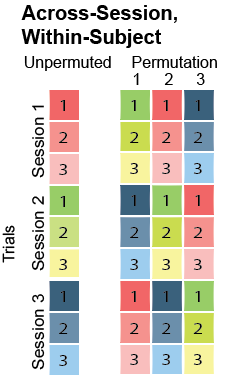

 **Figure 5B** in [Vidaurre et al. 2023](https://arxiv.org/abs/2312.07151#:~:text=GLHMM%20is%20implemented%20as%20a,sets%20at%20reasonable%20computational%20time): A 9 x 4 matrix representing permutation testing across sessions. Each number corresponds to a trial within a session and permutations are performed between sessions, with each session containing the same number of trials.


**Hypothesis**
* Null Hypothesis (H0): No significant relationship exists between the independent variables and the dependent variable.
* Alternative Hypothesis (H1):: There is a significant relationship between the independent variables and the dependent variable.



### Across-sessions within subject testing - Multivariate<a id="perm-regression"></a>
In this multivariate test, we are using permutation testing to examine how the brain activity (gamma_epoch) relate to what the person sees (animate or inanimate objects) across different sessions. By using $R^2$, we assess how well the variation in brain activity across multiple states can explain the differences in stimuli. This test is particularly valuable for assessing whether a subject's perception changes over time.

If there is no difference in brain activity between sessions, it suggests that the brain’s response to the stimuli is consistent over time. However, if we detect differences using $R^2$, this could indicate that the subject's perception of the task changes over time, as reflected by variations in brain activity across sessions."

**Run the test_across_sessions_within_subject function:**\
To set the wheels in motion for the ```test_across_sessions_within_subject``` function, input the variables ```Gamma_reconstruct``` (D) and ```R_session``` (R). Additionally, you can account for potential confounding variables by regressing them out through permutation testing. Initiating regression-based permutation testing involves setting ```method="multivariate"```. For an in-depth comprehension of the function look at the documentation.

In [119]:
# Set the parameters for across sessions within subject testing
method = "multivariate"
Nperm = 1000 # Number of permutations (default = 0)
test_statistic = True
# Perform across-subject testing
result_multivariate_session  =statistics.test_across_sessions_within_subject(Gamma_reconstruct, R_sessions, idx_sessions,method=method,Nperm=Nperm, test_statistics_option=True)

Maximum number of permutations with 10 sessions is: 3.63e+06
performing permutation testing per timepoint


100%|██████████| 250/250 [00:56<00:00,  4.46it/s]


We can now examine the local ```result_regression_session``` variable.

In [121]:
result_multivariate_session

{'pval': array([0.46953047, 0.59240759, 0.8991009 , 0.91108891, 0.83116883,
        0.43756244, 0.47552448, 0.95904096, 0.16883117, 0.85414585,
        0.07092907, 0.07692308, 0.38461538, 0.96903097, 0.83216783,
        0.76623377, 0.78521479, 0.98301698, 0.07192807, 0.13286713,
        0.08691309, 0.002997  , 0.0959041 , 0.18081918, 0.51248751,
        0.50749251, 0.9040959 , 0.96603397, 0.12487512, 0.54445554,
        0.42657343, 0.06593407, 0.08391608, 0.04295704, 0.05594406,
        0.0969031 , 0.00999001, 0.01798202, 0.03096903, 0.00699301,
        0.000999  , 0.001998  , 0.03296703, 0.01498501, 0.002997  ,
        0.02997003, 0.00599401, 0.000999  , 0.01698302, 0.00999001,
        0.00999001, 0.00999001, 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.001998  , 0.000999  , 0.01298701,
        0.000999  , 0.000999  , 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999

What we can see here is that ```result_regression_session``` is a dictionary containing the outcomes of a statistical analysis conducted using the specified ```method``` and ```test_type```. 

Let us break it down:
* ```pval```: This array holds the p-values resulting from the permutation test. Each value corresponds to a behavioral variable and will have shape of 1 by q, see [paper](https://www.biorxiv.org/content/10.1101/2023.01.03.522583v4).

* ```base_statistics```: Stores the base statistics of the tests. In this case it is the explained variance $R^2$

* ```test_statistic```: Will by default always return a list of the base (unpermuted) statistics when ```test_statistic_option=False```. This list can store the test statistics associated with the permutation test. It provides information about the permutation distribution that is used to calculate the p-values. The output will exported if we set ```test_statistic_option=True```

* ```statistical_measures```: A dictionary that marks the units used as test_statistics

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_sessions_within_subject```.

* ```method```: Specifies the analytical method employed, which is ```'multivariate'```, which means that the analysis is carried out using regression-based permutation testing.

* ```max_correction```: Boolean value that indicates whether Max correction has been applied when performing permutation testing

* ```Nperm```: Is the number of permutations that has been performed.


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.\
We will use the function ```plot_heatmap``` from the ```graphics``` module.

Note: Elements marked in red indicate a p-value below 0.05, signifying statistical significance.

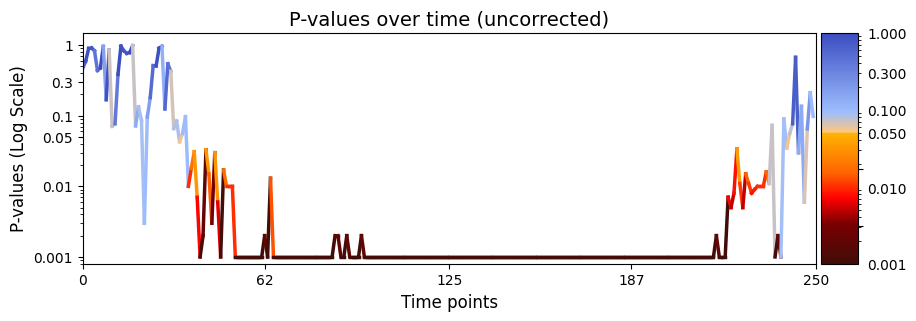

In [122]:
# The alpha score we set for the p-values
alpha = 0.05
# Plot p-values
graphics.plot_p_values_over_time(result_multivariate_session["pval"], 
                                 title_text ="P-values over time (uncorrected)",figsize=(10, 3), 
                                 xlabel="Time points", alpha=alpha)

**Multiple Comparison**\
To take into account for type 1 error, we can apply the Bonferroni correction.

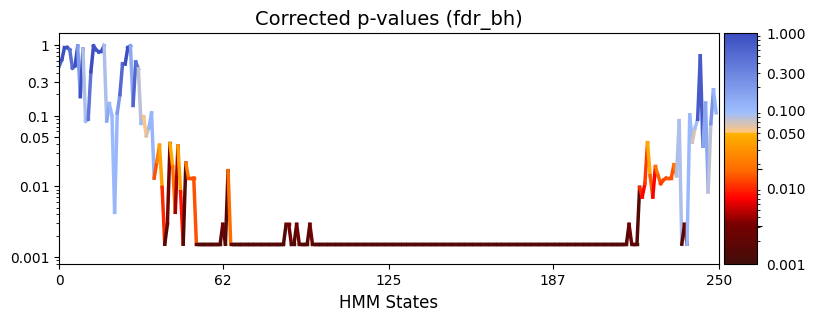

In [123]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_multivariate_session["pval"], method='fdr_bh')
# Plot p-values
graphics.plot_p_values_over_time(pval_corrected, title_text ="Corrected p-values (fdr_bh)",figsize=(9, 3), xlabel="HMM States", ylabel="")

**Cluster based permutation testing**\
In order to provide a more strict control over Type I mistakes, we can also apply cluster-based permutation testing to control the Family-Wise Error Rate when conducting multiple comparisons.
To use this p-value correction, set ```test_statistics_option=True``` while performing permutation testing, as it is an input to the function (```pval_cluster_based_correction```).

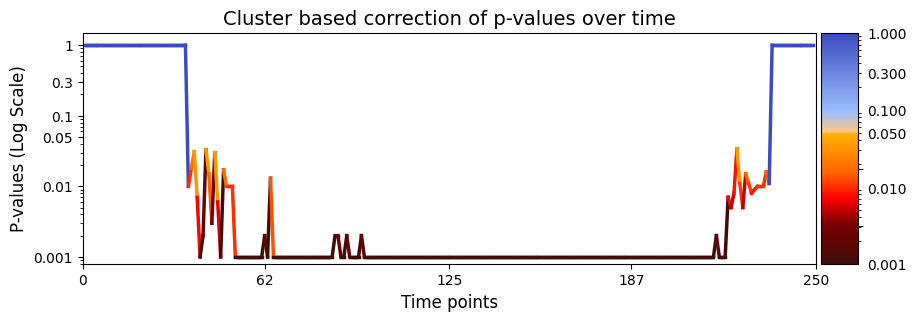

In [124]:
pval_cluster =statistics.pval_cluster_based_correction(result_multivariate_session["test_statistics"],result_multivariate_session["pval"])
# Plot p-values
graphics.plot_p_values_over_time(pval_cluster, title_text ="Cluster based correction of p-values over time",figsize=(10, 3), xlabel="Time points")

We can now compare if the results from ```result_regression_trials["pval"]``` correspond to the average probability for each state

intervals of significant p-values:
[(21, 21), (33, 33), (36, 234), (236, 238), (240, 240), (244, 244), (246, 246)]


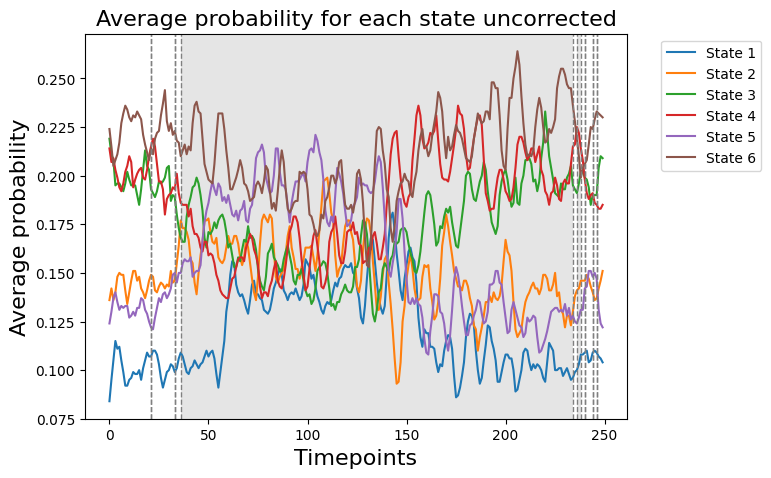

In [125]:
# Detect the intervals of when there is a significant difference, will be highlighed
alpha = 0.05
intervals =statistics.detect_significant_intervals(result_multivariate_session["pval"], alpha)
print(f"intervals of significant p-values:\n{intervals}")
title = "Average probability for each state uncorrected"
graphics.plot_average_probability(Gamma_reconstruct, vertical_lines=intervals, highlight_boxes=True, title=title)


Detect intervals of significant differences using the cluster based p value correction.

intervals of significant p-values:
[(36, 234)]


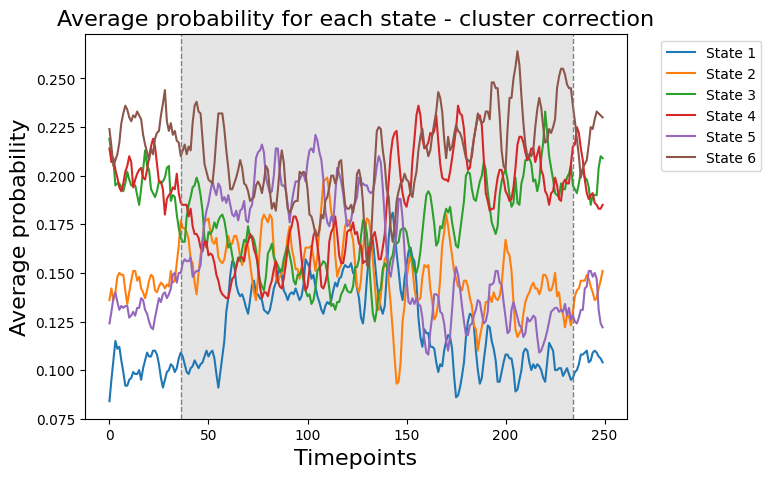

In [126]:
# Detect the intervals of when there is a significant difference, will be highlighed
alpha = 0.05
intervals =statistics.detect_significant_intervals(pval_cluster, alpha)
print(f"intervals of significant p-values:\n{intervals}")
title = "Average probability for each state - cluster correction"
graphics.plot_average_probability(Gamma_reconstruct, vertical_lines=intervals, highlight_boxes=True, title=title)


#### Conclusion - Multivariate test
In the permutation testing across sessions, we aimed to find out how state time courses (D) and reaction time (R) are related across various experimental sessions, all while keeping the trial order in the same. The analysis gave us a variable called ```pval```, packed with 250 p-values, each matching up with a specific time point in our experiment.

Now, the interesting bit: Statistically speaking, the test showed that different time windows (espicially timepoints 37 to 81 ) showed a significant difference and means that the state time courses (D) are related with changes in reaction time (R). In the context of an experiment, this could represent an important period of cognitive or neural processing relevant to the given task, depending on the experimental design.

### Across-trials within session testing - Multivariate <a id="perm-regression-trial"></a>
From our previous result, it is evident that there are variations at specific time windows across multiple sessions. This indicates significant changes occurring during each experimental session in which the subject is involved.

An intriguing aspect of this dataset is the opportunity to delve into trial-by-trial variability within each experimental session. Even though we observe a significant difference across sessions, it's possible that there are specific periods across trials that shows variability. This hypothesis can be tested using the function ```across_trials_within_session```.





**Run the across_trials_within_session function:**\
We do not need to change any input variables to run this test compare to earlier. Just insert input the variables ```Gamma_reconstruct``` (D) and ```R_session``` (R). Additionally, you can account for potential confounding variables by regressing them out through permutation testing. Initiating regression-based permutation testing involves setting ```method="regression"```. For an in-depth comprehension of the function look at the documentation.

In [45]:
# Set the parameters for across trials testing
method = "multivariate"
Nperm = 1000 # Number of permutations (default = 1000)
test_statistics_option = True

# Perform across-trial testing
result_multivaraite_trials  =statistics.test_across_trials(Gamma_reconstruct, R_sessions, idx_sessions,method=method,
                                                                 Nperm=Nperm, test_statistics_option=test_statistics_option)


performing permutation testing per timepoint


100%|██████████| 250/250 [02:36<00:00,  1.60it/s]


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.\
We will use the function ```plot_heatmap``` from the ```graphics``` module.

Note: Elements marked in red indicate a p-value below 0.05, signifying statistical significance.

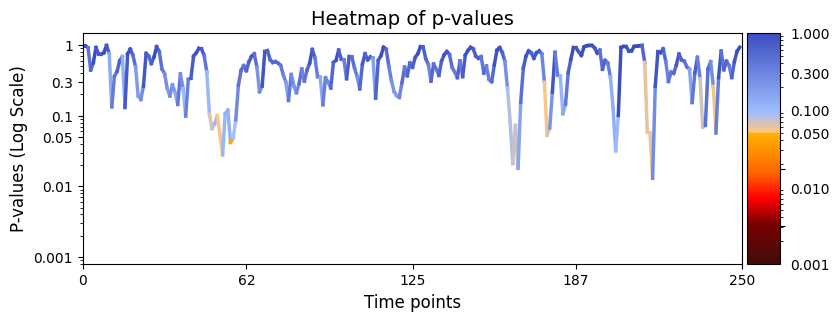

In [127]:
# Plot p-values
graphics.plot_p_values_over_time(result_multivaraite_trials["pval"], title_text ="Heatmap of p-values",figsize=(9, 3), xlabel="Time points")

**Multiple Comparison**\
To take into account for type 1 error, we can apply the Benjamini/Hochberg correction.

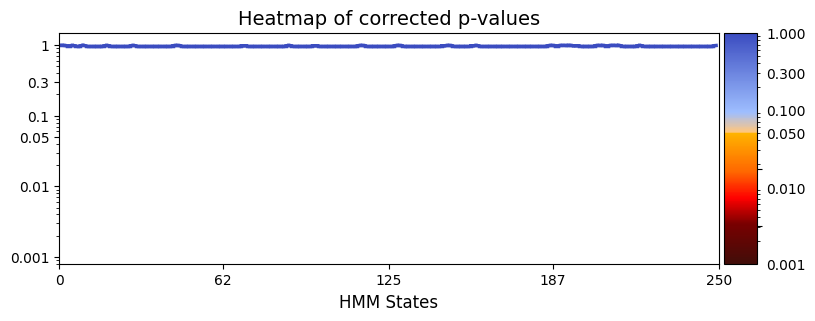

In [128]:
alpha = 0.05
pval_corrected, rejected_corrected =statistics.pval_correction(result_multivaraite_trials["pval"], method='fdr_bh',alpha=alpha)
# Plot p-values
graphics.plot_p_values_over_time(pval_corrected, title_text ="Heatmap of corrected p-values",figsize=(9, 3), xlabel="HMM States", ylabel="")

**Cluster based permutation testing**\
In order to provide a more strict control over Type I mistakes, we can also apply cluster-based permutation testing to control the Family-Wise Error Rate when conducting multiple comparisons.


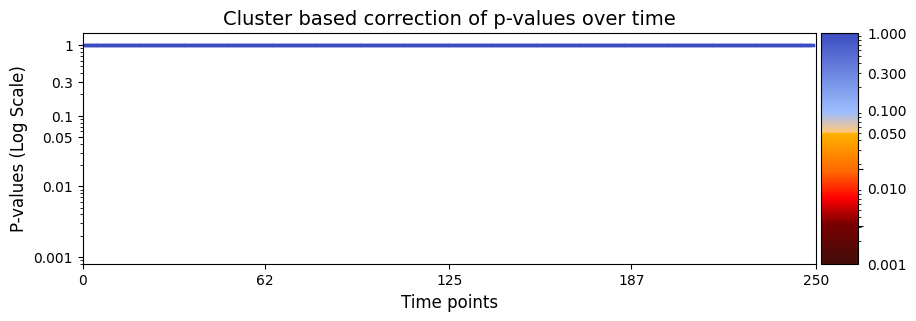

In [129]:
pval_cluster =statistics.pval_cluster_based_correction(result_multivaraite_trials["test_statistics"],result_multivaraite_trials["pval"])
# Plot p-values
graphics.plot_p_values_over_time(pval_cluster, title_text ="Cluster based correction of p-values over time",figsize=(10, 3), xlabel="Time points")

#### Conclusion - Multivariate trials
In the permutation testing across trials, we tried to find out the relationship between state time courses (D) and reaction time (R) throughout different trials within experimental sessions. 

There were no significant differences across the time points after correcting the p-values. This suggests a stable relationship between state time courses and reaction time throughout trials within each experimental session. This consistency implies that, on the given session or day, the subject's performance remains relatively unchanged/stable in terms of the observed state time courses and corresponding reaction times.\
This finding aligns well with how the data was constructed, as changes in reaction time were relatively consistent across trials within each session, but had varying values across different sessions.

Although the main goal of this tutorial was to look at variability within a subject between sessions, it is wise to also take trial-to-trial variability within a session into consideration. This additional test gives us a more complete picture of the data and helps us to account for any shifts in performance at a finer level of detail.

### Across-sessions within subject testing - Univariate<a id="perm-correlation"></a>
In correlation analysis, our goal is to explore the association between predictor variables (D) and the response variable (R). Our focus is on identifying the strength of the linear relationship between the state time courses  (```Gamma_reconstruct```) and behavioral measurements, such as 'reaction time'.\
If the result is significant, it means that certain patterns in the state time courses (```Gamma_reconstruct```) contributes in explaining the variability in behavioral measurements across sessions.
On the flip side, a non-significant result suggests that the observed relationship might just be a random thing, implying that our state time courses might not explain the variability in behavioral measurements.

**Executing the across_sessions_within_subject Function**:\
To initiate the ```across_sessions_within_subject``` function using the univariate approach, input the variables ```Gamma_reconstruct``` (D) and ```R_session``` (R) and set ```method="univariate"```. Additionally, you can address potential confounding variables by incorporating permutation testing. 

In [60]:
# Set the parameters for between-subject testing
method = "univariate"
Nperm = 1000 # Number of permutations (default = 1000)
# Perform across-subject testing
result_univariate =statistics.test_across_sessions_within_subject(Gamma_reconstruct, R_sessions, idx_sessions,method=method,Nperm=Nperm, test_statistics_option=True)

Maximum number of permutations with 10 sessions is: 3.63e+06
performing permutation testing per timepoint


100%|██████████| 250/250 [10:58<00:00,  2.63s/it]


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value matrix.\
We will use the function ```plot_heatmap``` from the ```graphics``` module.

Note: Elements marked in red indicate a p-value below 0.05, signifying statistical significance.

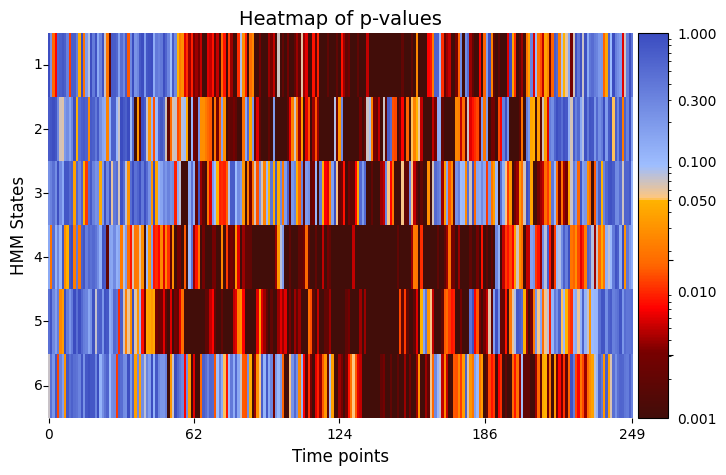

In [61]:
# Plot p-values
# P-values between reaction time and each state as function of time
graphics.plot_p_value_matrix(result_univariate["pval"].T, title_text ="Heatmap of p-values",figsize=(8, 5), xlabel="Time points", ylabel="HMM States", annot=False)

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

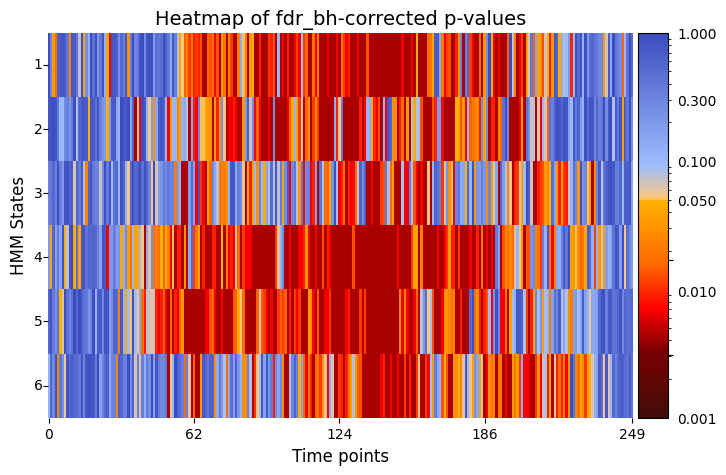

In [62]:
alpha = 0.05 # threshold for p-values
pval_corrected, rejected_corrected =statistics.pval_correction(result_univariate["pval"], method='fdr_bh', alpha=0.5)
# Plot p-values
graphics.plot_p_value_matrix(pval_corrected.T, title_text ="Heatmap of fdr_bh-corrected p-values",figsize=(8, 5), xlabel="Time points", ylabel="HMM States", annot=False, alpha = alpha)

**Cluster based permutation testing**\
In order to provide a more strict control over Type I mistakes, we can also apply cluster-based permutation testing to control the Family-Wise Error Rate when conducting multiple comparisons.

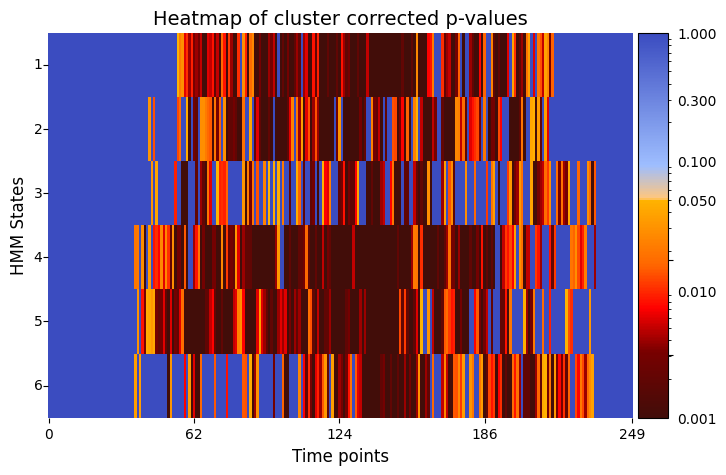

In [63]:
pval_cluster =statistics.pval_cluster_based_correction(result_univariate["test_statistics"],result_univariate["pval"])
# Plot p-values
graphics.plot_p_value_matrix(pval_cluster.T, title_text ="Heatmap of cluster corrected p-values",figsize=(8, 5), xlabel="Time points", ylabel="HMM States", annot=False, alpha = alpha)

#### Conclusion - Univariate
The analysis uses a univariate permutation test to compare the relationship between each brain state, identified by the HMM, and reaction times across different experimental sessions. The results are shown in a matrix (time points x states) that highlights how the connection between each brain state at certain times and the reaction times changes across sessions.

A significant p-value for a specific brain state and time point indicates that the relationship between the state and reaction time differs across sessions at that moment. This means that session-specific variations occur during those times.

However, it's important to interpret these results in the context of your experiment and research questions. Any differences between sessions could reflect important changes in the brain-behavior relationship that are relevant to your study. Understanding these findings within the framework of your experiment is essential for drawing meaningful conclusions.